# TalkingData AdTracking Fraud Detection Challenge

### 1. 출처 : [Kaggle - TalkingData AdTracking Fraud Detection Challenge](https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/)


### 2. 목표 : 모바일 앱 광고에 대한 사기성 클릭 트래픽 감지


### 3. Column 설명

- ip: 클릭한 ip 주소
- app: 마케팅 app id
- device: 휴대전화 기기 종류
- os: 휴대전화 OS 버전
- channel: 모바일 광고 게시자의 채널 id
- click_time: 접속 시간 (UTC)
- attributed_time: 사용자가 광고를 클릭 한 후 앱을 다운로드 한 경우 앱 다운로드 시점
- is_attributed: 앱이 다운로드 되었음을 나타내는 예측할 대상

---

# Library 불러오기

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline

import datetime
import time

import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Mac OS를 이용하고 있기 떄문에 AppleGothic을 설정했습니다.
# 윈도우의 경우 다른 폰트를 사용해주셔야 합니다. 나눔폰트가 있는 경우 'NanumGothic' 없는 경우에는 'Malgun Gothic'을 사용해주세요.
matplotlib.rc('font', family='AppleGothic')
#matplotlib.rc('font', family='Malgun Gothic')

# 별도로, 폰트를 바꿀 경우 마이너스가 표시되지 않는 경우도 있는데 이를 막아주는 코드입니다.
matplotlib.rc('axes', unicode_minus=False)
matplotlib.rcParams['axes.unicode_minus'] = False

# retina 옵션을 통해 해상도를 올립니다.
set_matplotlib_formats('retina')

# 화면에 출력하는 데이터 프레임의 최대 row 수를 500으로 설정합니다.
pd.set_option('display.max_rows', 500)

# 화면에 출력하는 데이터 프레임의 최대 column 수를 500으로 설정합니다.
pd.set_option('display.max_columns', 500)

In [5]:
sns.set(style = "whitegrid", rc = {'figure.figsize':(16, 6)})
plt.figure(figsize = (16, 6))

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

---

# Data 불러오기

In [6]:
train = pd.read_csv("data/train_sample.csv")

print(train.shape)
train.head()

(100000, 8)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


---

# Data Check

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


---

# 결측치 확인

In [8]:
train.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

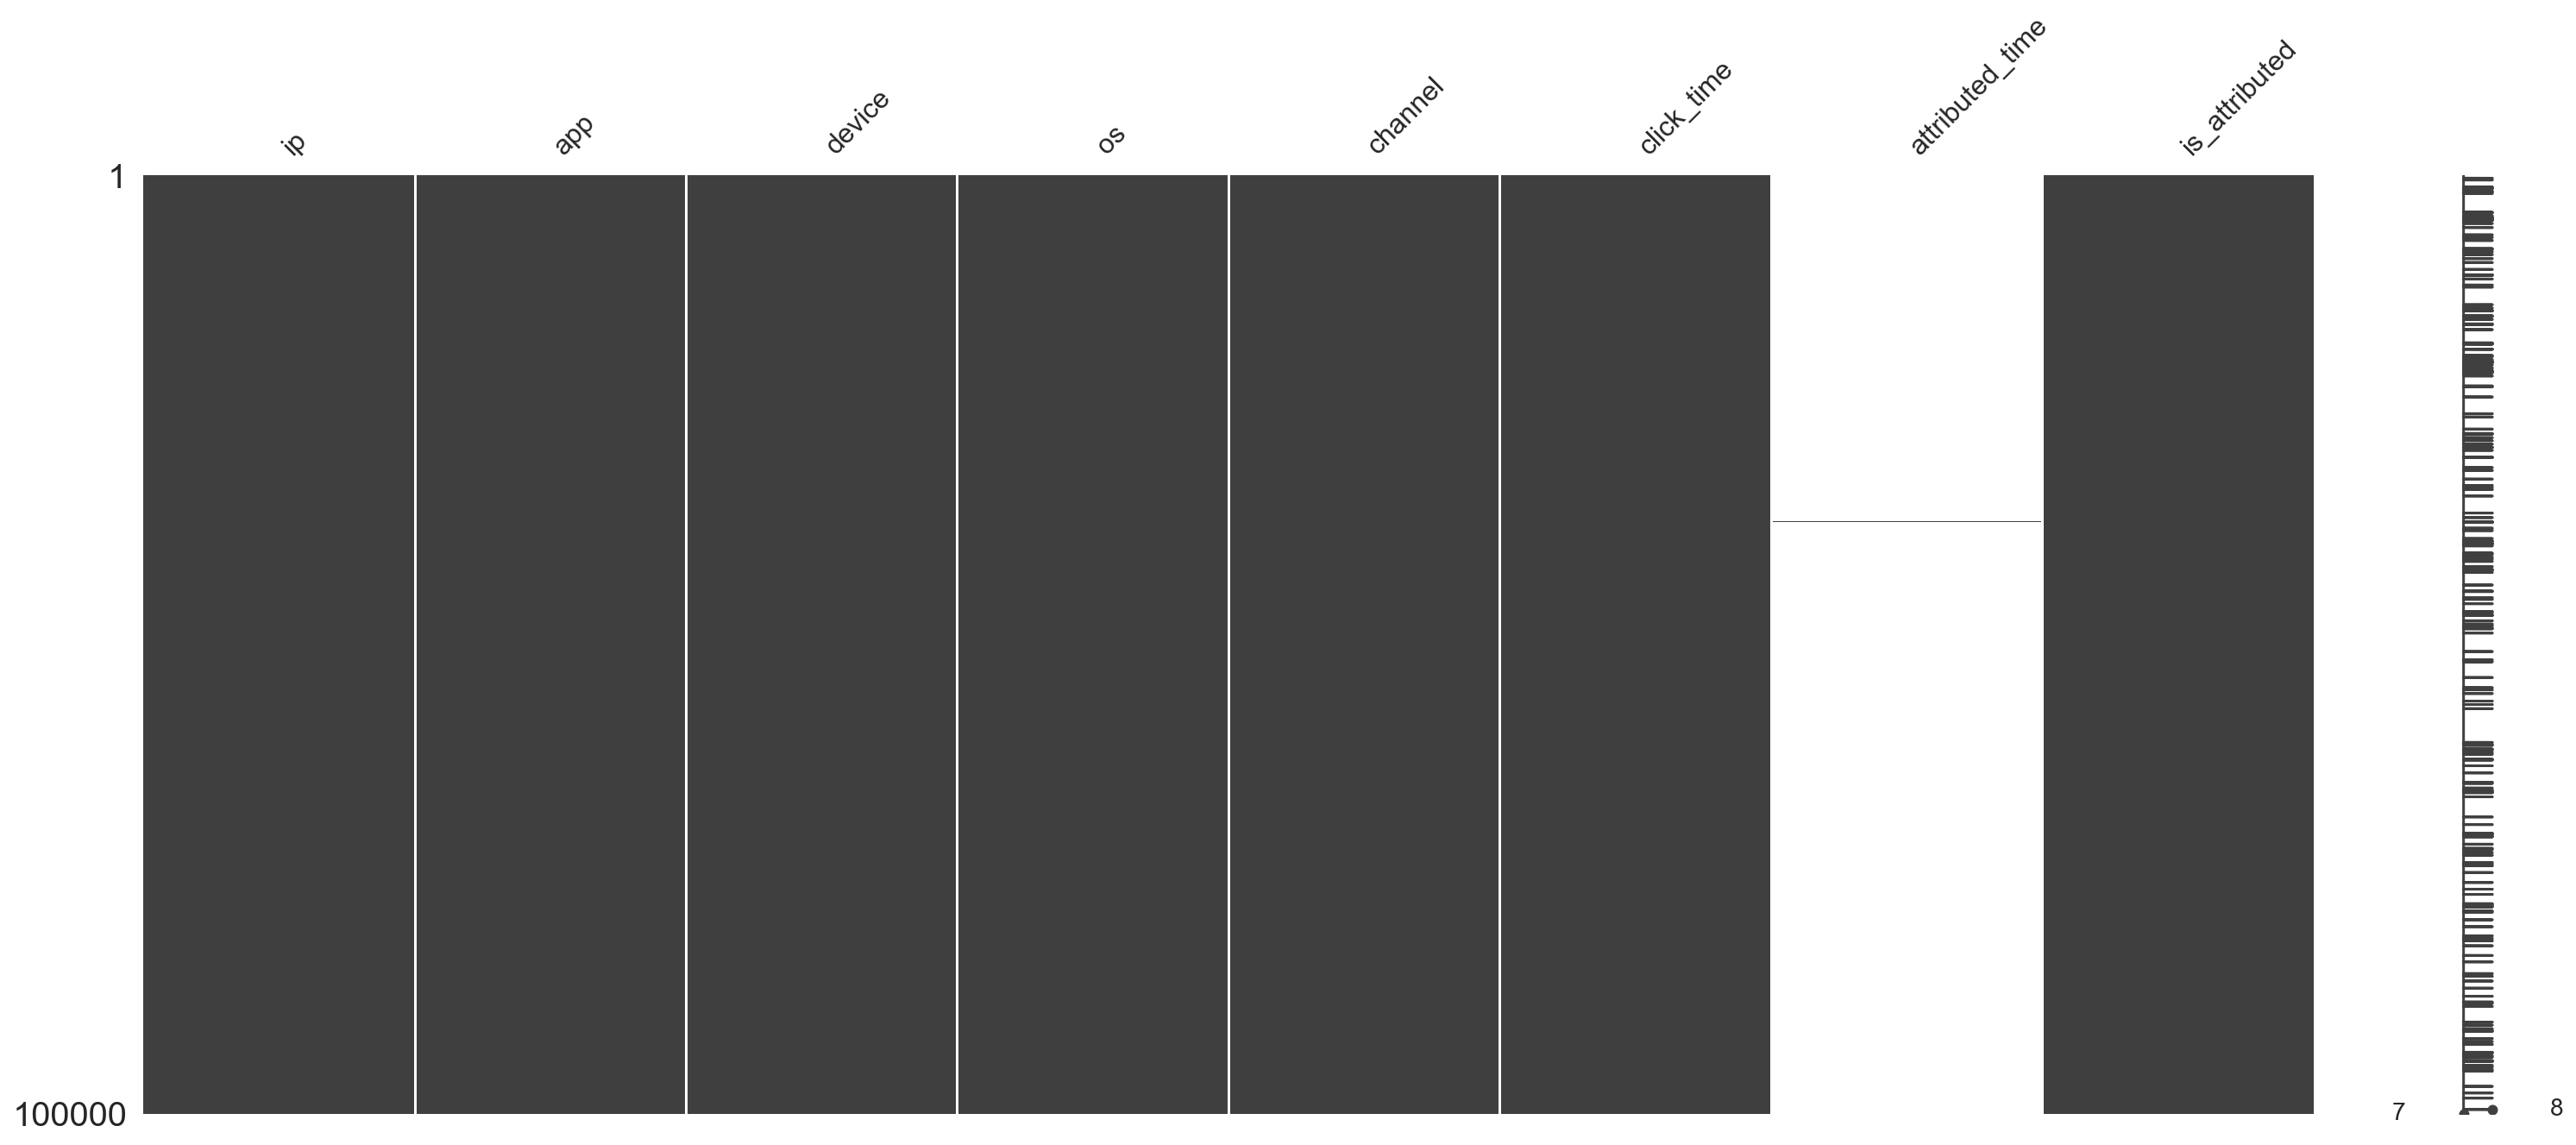

In [9]:
import missingno as msno

msno.matrix(train)

attributed_time 컬럼은 거의 대부분 NaN 값을 가지고 있습니다. 즉, 대부분의 사람들이 다운로드를 하지 않았다는 뜻으로 해석할 수 있습니다.

---

# Pre-Processing

## click_time 전처리

click_time 컬럼을 연/월/일/시/분/초/요일 로 변환합니다.

In [10]:
train["click_time"] = pd.to_datetime(train["click_time"])

train["click_time_year"] = pd.to_datetime(train["click_time"]).dt.year
train["click_time_month"] = pd.to_datetime(train["click_time"]).dt.month
train["click_time_day"] = pd.to_datetime(train["click_time"]).dt.day
train["click_time_hour"] = pd.to_datetime(train["click_time"]).dt.hour
train["click_time_minute"] = pd.to_datetime(train["click_time"]).dt.minute
train["click_time_weekday"] = pd.to_datetime(train["click_time"]).dt.weekday_name

print(train.shape)
train[["click_time", "click_time_year", "click_time_month", "click_time_day",
      "click_time_hour", "click_time_minute", "click_time_weekday"]].head()

(100000, 14)


,click_time,click_time_year,click_time_month,click_time_day,click_time_hour,click_time_minute,click_time_weekday
0,2017-11-07 09:30:38,2017,11,7,9,30,Tuesday
1,2017-11-07 13:40:27,2017,11,7,13,40,Tuesday
2,2017-11-07 18:05:24,2017,11,7,18,5,Tuesday
3,2017-11-07 04:58:08,2017,11,7,4,58,Tuesday
4,2017-11-09 09:00:09,2017,11,9,9,0,Thursday


## attributed_time 컬럼

attributed_time 컬럼을 연/월/일/시/분/초/요일로 변경합니다.

In [11]:
train["attributed_time"] = pd.to_datetime(train["attributed_time"])

train["attributed_time_year"] = pd.to_datetime(train["attributed_time"]).dt.year
train["attributed_time_month"] = pd.to_datetime(train["attributed_time"]).dt.month
train["attributed_time_day"] = pd.to_datetime(train["attributed_time"]).dt.day
train["attributed_time_hour"] = pd.to_datetime(train["attributed_time"]).dt.hour
train["attributed_time_minute"] = pd.to_datetime(train["attributed_time"]).dt.minute
train["attributed_time_weekday"] = pd.to_datetime(train["attributed_time"]).dt.weekday_name

print(train.shape)
train[["attributed_time", "attributed_time_year", "attributed_time_month", "attributed_time_day",
      "attributed_time_hour", "attributed_time_minute", "attributed_time_weekday"]].head()

(100000, 20)


,attributed_time,attributed_time_year,attributed_time_month,attributed_time_day,attributed_time_hour,attributed_time_minute,attributed_time_weekday
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN


---

# E.D.A

## ip 컬럼

In [13]:
train["ip"].value_counts().head()

5348     669
5314     616
73487    439
73516    399
53454    280
Name: ip, dtype: int64

In [14]:
ip_table = pd.pivot_table(train, index = "ip",
                          values = "is_attributed",
                          aggfunc = ["mean", "count"])

ip_table.columns = ["download_rate", "click_count"]

ip_table = ip_table.sort_values(by = "click_count", ascending = False).reset_index()

ip_table.head()

,ip,download_rate,click_count
0,5348,0.004484,669
1,5314,0.004870,616
2,73487,0.000000,439
3,73516,0.000000,399
4,53454,0.000000,280


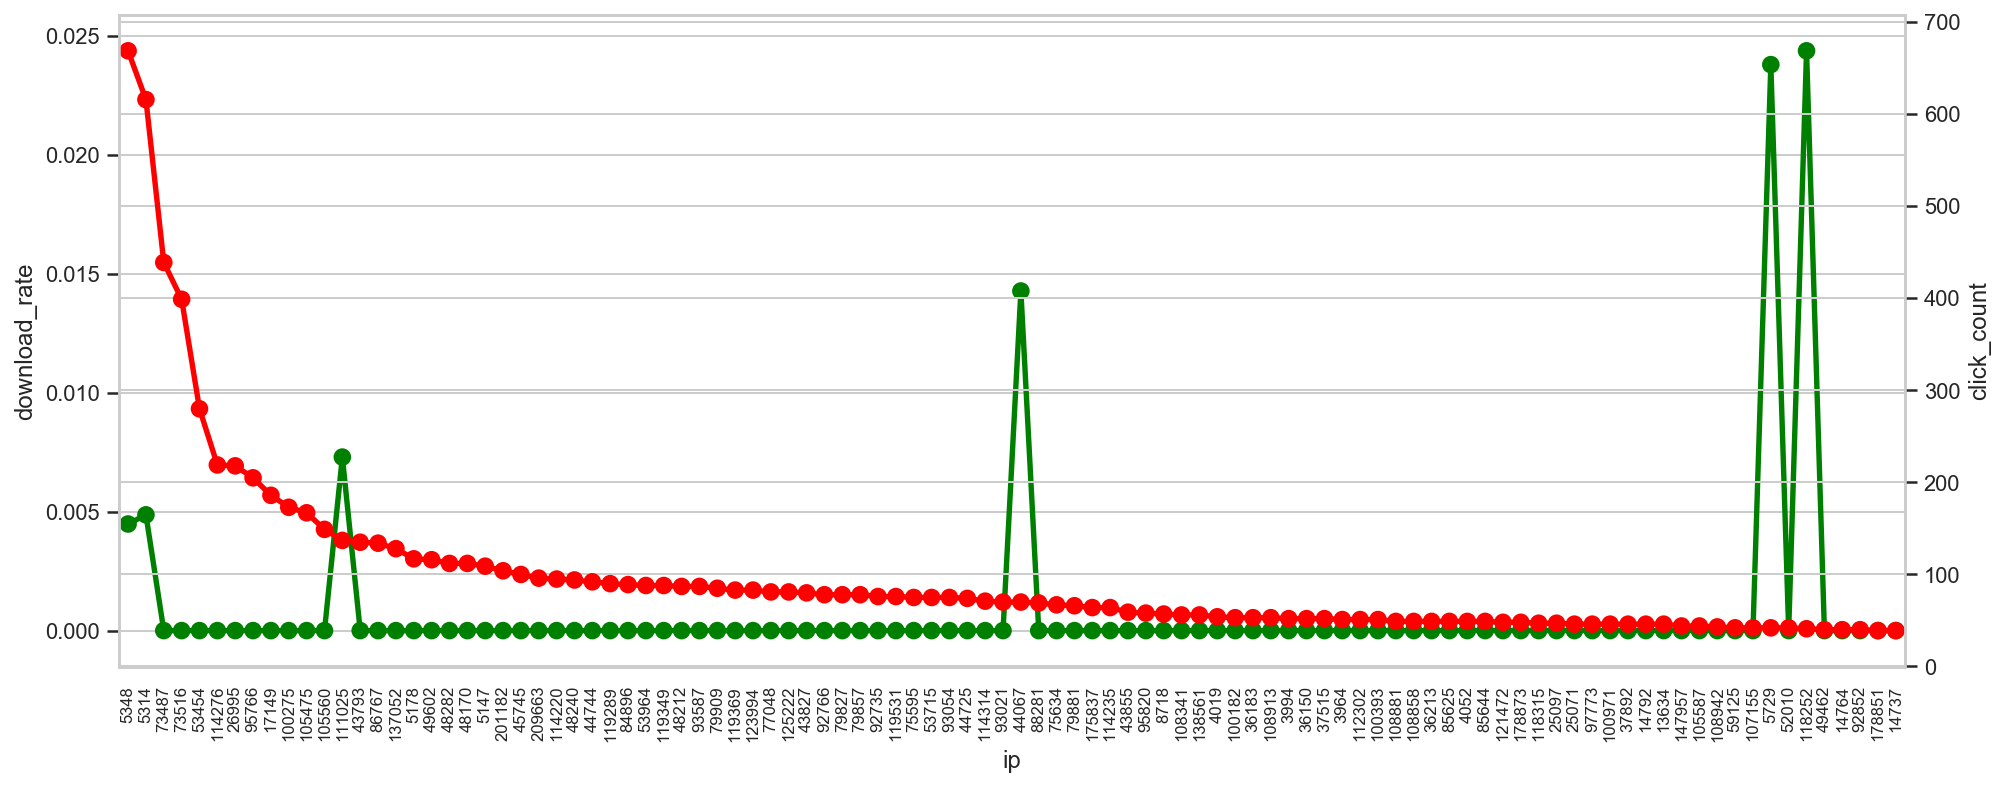

In [15]:
order_ip = ip_table["ip"].head(100).unique()

ax = sns.pointplot(data = ip_table[:100], x = "ip", y = "download_rate",
                   color = "green",
                   order = order_ip)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.twinx()

ax = sns.pointplot(data = ip_table[:100], x = "ip", y = "click_count",
                   color = "red",
                   order = order_ip)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.show()

ip의 접속 횟수와 다운로드와는 상관 관계가 없는 것으로 보입니다.

## app 컬럼

In [16]:
train["app"].value_counts().head()

3     18279
12    13198
2     11737
9      8992
15     8595
Name: app, dtype: int64

In [17]:
app_table = pd.pivot_table(train, index = "app",
                           values = "is_attributed",
                           aggfunc = ["mean", "count"])

app_table.columns = ["download_rate", "click_count"]

app_table = app_table.sort_values(by = "click_count", ascending = False).reset_index()

app_table.head()

,app,download_rate,click_count
0,3,0.000219,18279
1,12,0.000076,13198
2,2,0.000000,11737
3,9,0.000890,8992
4,15,0.000233,8595


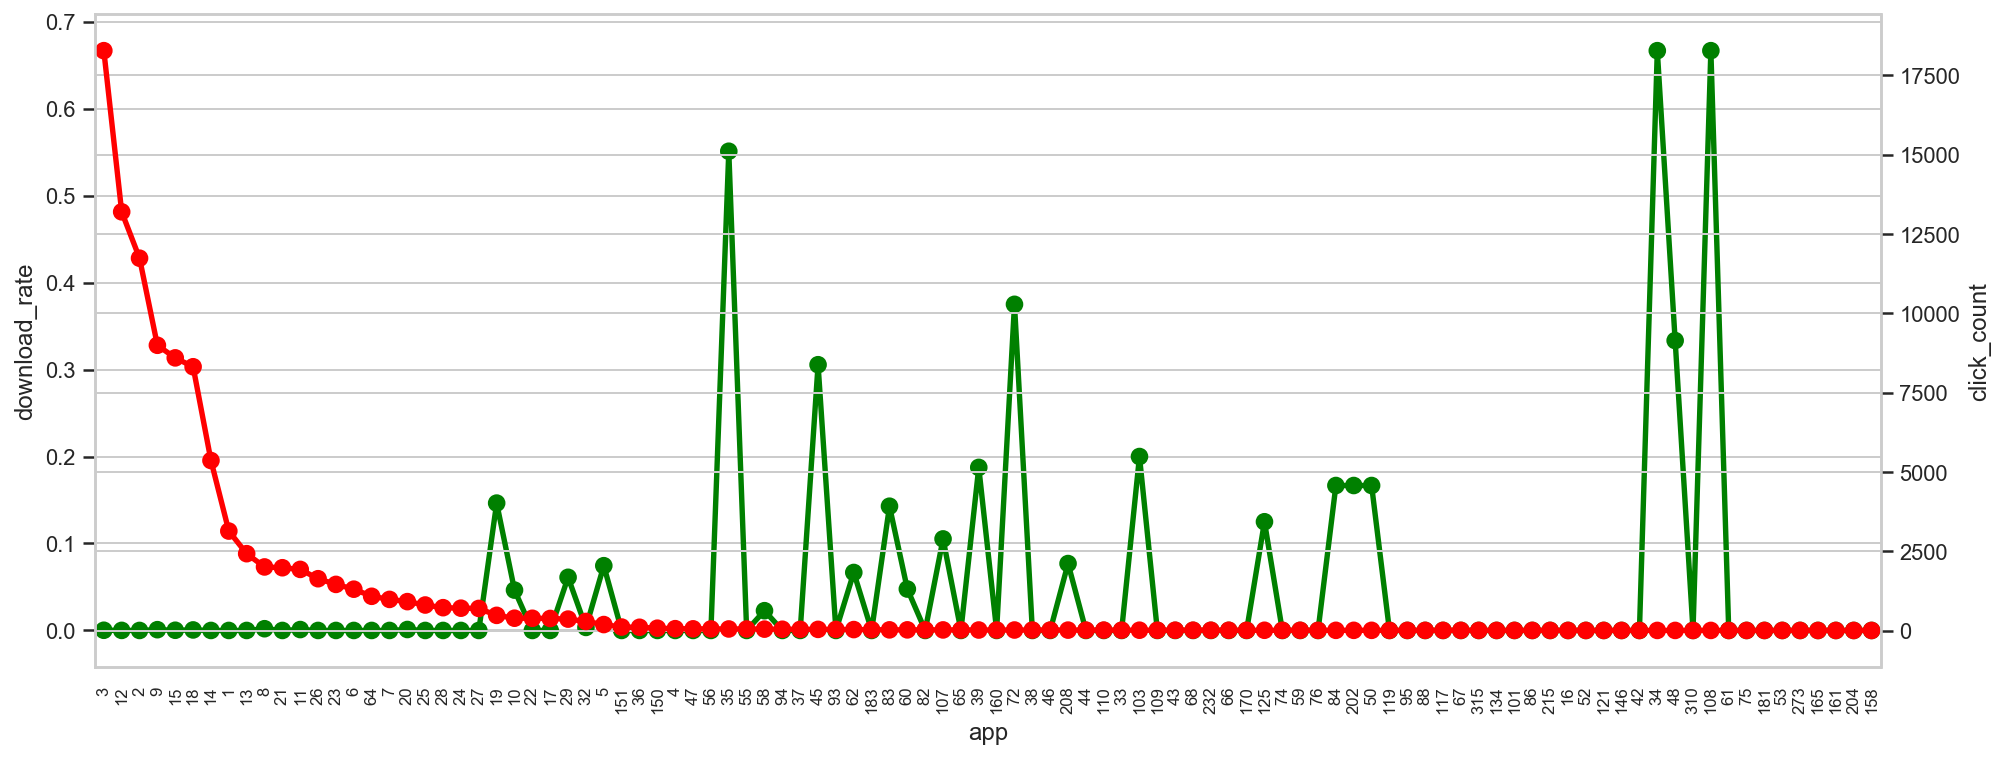

In [18]:
order_app = app_table["app"].head(100).unique()

ax = sns.pointplot(data = app_table, x = "app", y = "download_rate",
                   color = "green",
                   order = order_app)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.twinx()

ax = sns.pointplot(data = app_table, x = "app", y = "click_count",
                   color = "red",
                   order = order_app)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.show()

app 별 접속 횟수도 다운로드에는 큰 영향이 없는 것 같습니다.

## device 컬럼

In [19]:
train["device"].value_counts().head()

1       94338
2        4345
0         541
3032      371
3543      151
Name: device, dtype: int64

In [20]:
device_table = pd.pivot_table(train, index = "device",
                              values = "is_attributed",
                              aggfunc = ["mean", "count"])

device_table.columns = ["download_rate", "click_count"]

device_table = device_table.sort_values(by = "click_count", ascending = False).reset_index()

device_table.head()

,device,download_rate,click_count
0,1,0.001548,94338
1,2,0.000460,4345
2,0,0.096118,541
3,3032,0.000000,371
4,3543,0.000000,151


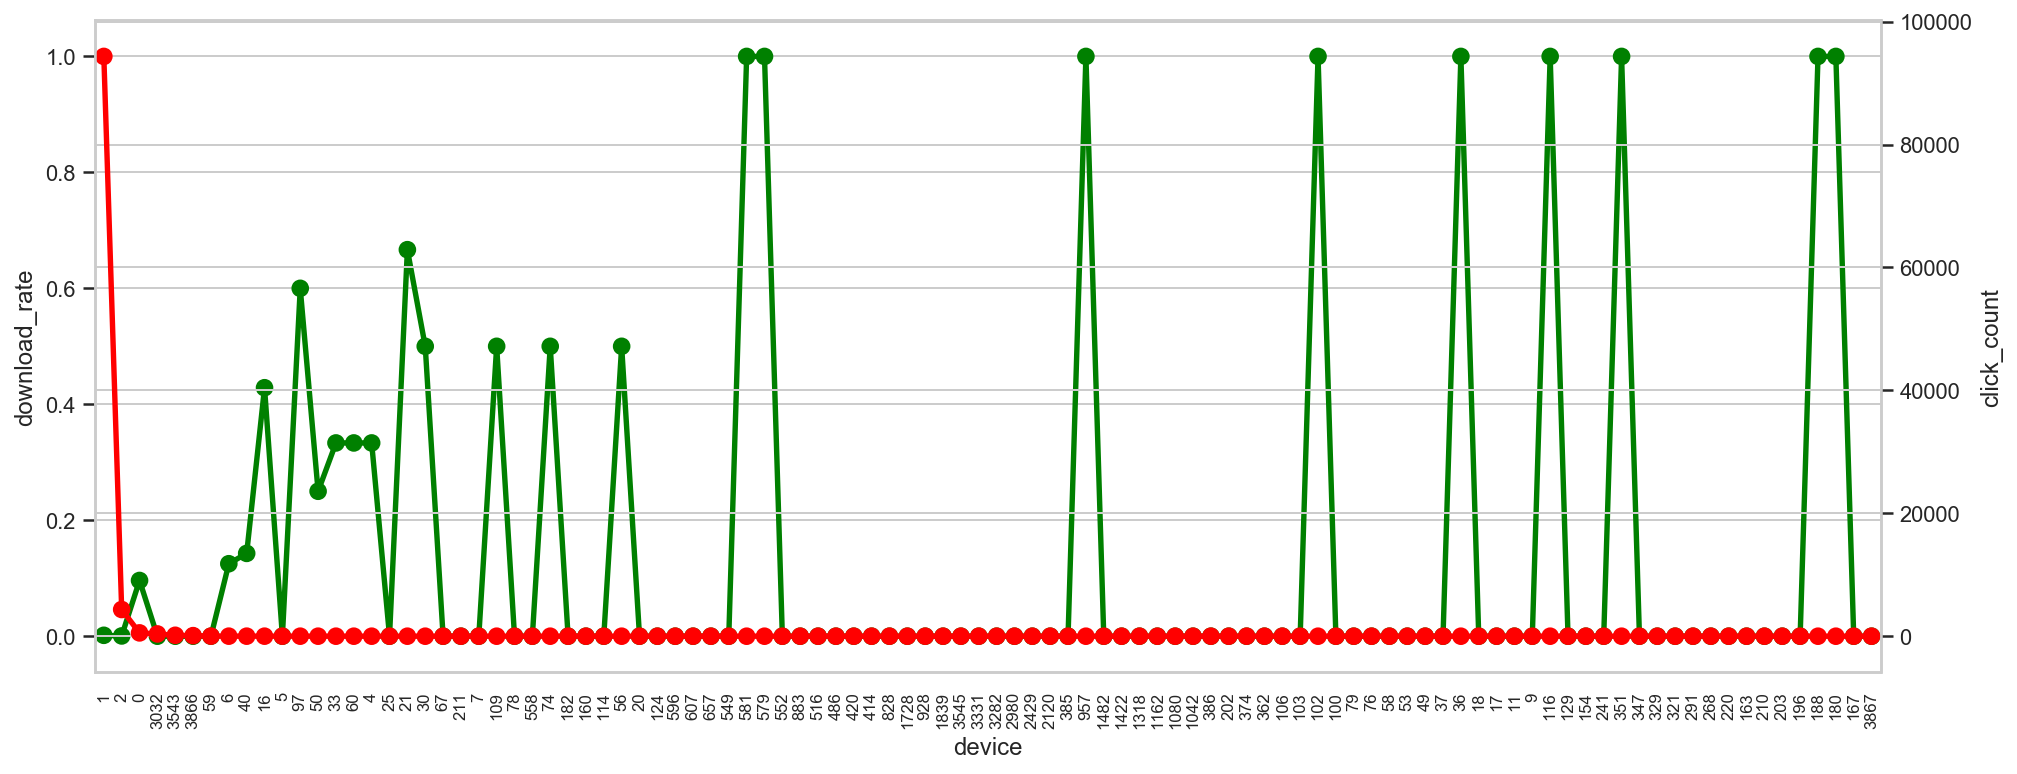

In [21]:
order_device = device_table["device"].unique()

ax = sns.pointplot(data = device_table, x = "device", y = "download_rate",
                   color = "green",
                   order = order_device)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.twinx()

ax = sns.pointplot(data = device_table, x = "device", y = "click_count",
                   color = "red",
                   order = order_device)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.show()

device 에 따른 다운로드 비율도 상관 관계가 없다는 것을 알 수 있습니다.

## os 컬럼

In [22]:
train["os"].value_counts().head()

19    23870
13    21223
17     5232
18     4830
22     4039
Name: os, dtype: int64

In [23]:
os_table = pd.pivot_table(train, index = "os",
                          values = "is_attributed",
                          aggfunc = ["mean", "count"])

os_table.columns = ["download_rate", "click_count"]

os_table = os_table.sort_values(by = "click_count", ascending = False).reset_index()

os_table.head()

,os,download_rate,click_count
0,19,0.001718,23870
1,13,0.001178,21223
2,17,0.001147,5232
3,18,0.000828,4830
4,22,0.001486,4039


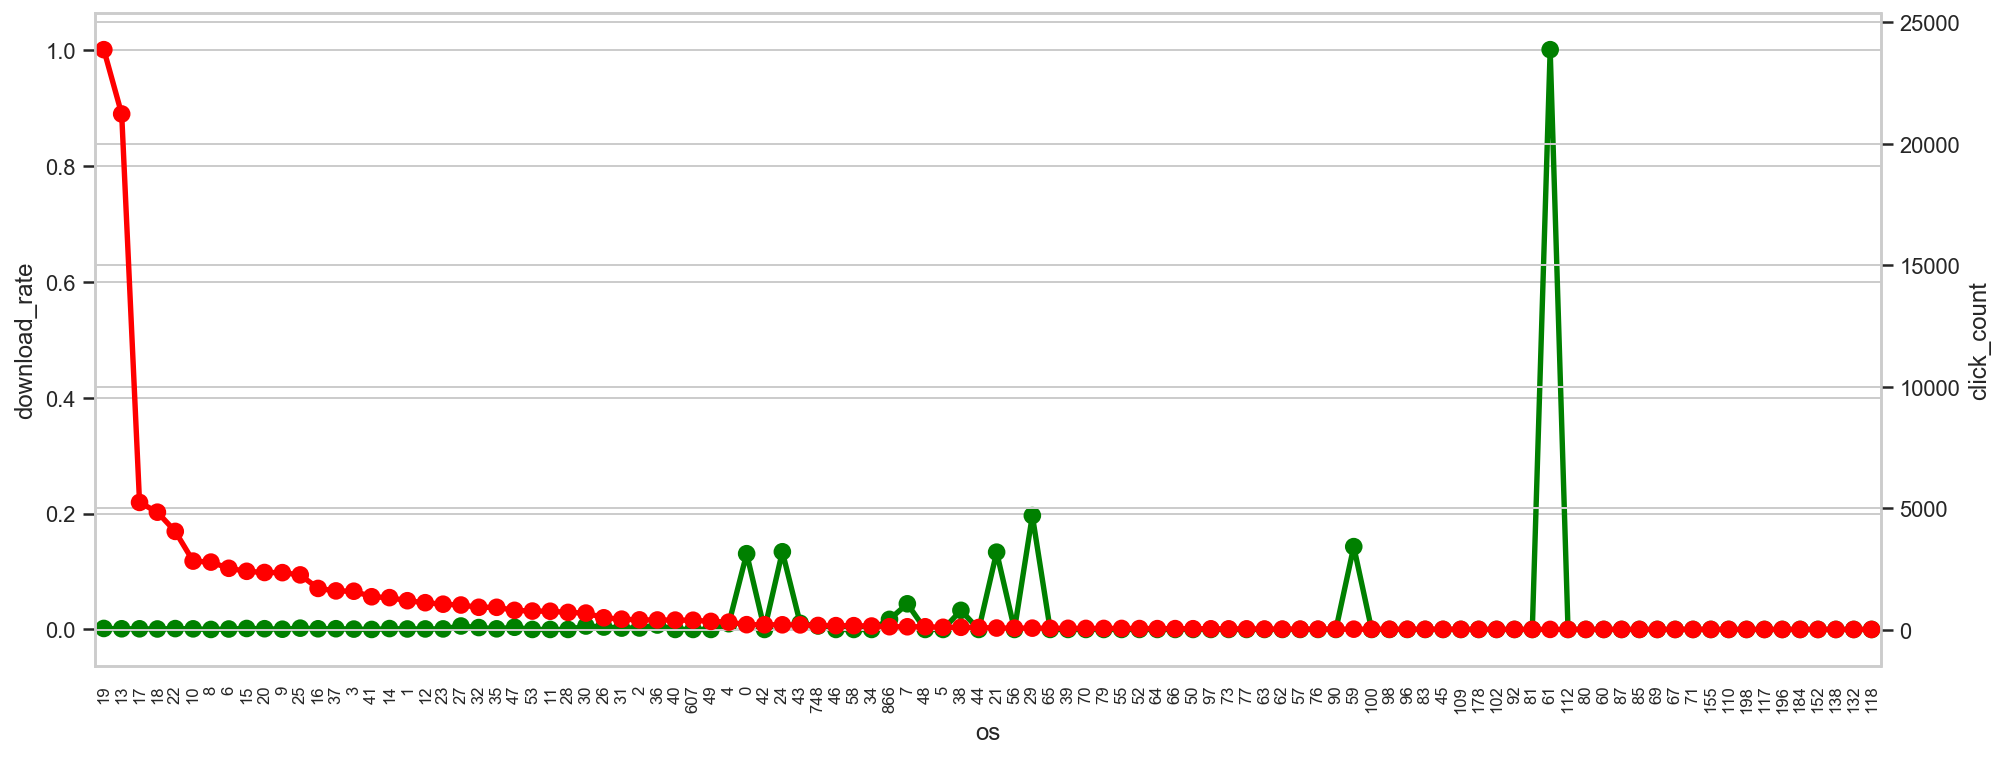

In [24]:
order_os = os_table["os"].head(100).unique()

ax = sns.pointplot(data = os_table[:100], x = "os", y = "download_rate",
                   color = "green",
                   order = order_os)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.twinx()

ax = sns.pointplot(data = os_table[:100], x = "os", y = "click_count",
                   color = "red",
                   order = order_os)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.show()

## channel 컬럼

In [25]:
train["channel"].value_counts().head()

280    8114
245    4802
107    4543
477    3960
134    3224
Name: channel, dtype: int64

In [26]:
channel_table = pd.pivot_table(train, index = "channel",
                               values = "is_attributed",
                               aggfunc = ["mean", "count"])

channel_table.columns = ["download_rate", "click_count"]

channel_table = channel_table.sort_values(by = "click_count", ascending = False).reset_index()

channel_table.head()

,channel,download_rate,click_count
0,280,0.000246,8114
1,245,0.000000,4802
2,107,0.000220,4543
3,477,0.000000,3960
4,134,0.000310,3224


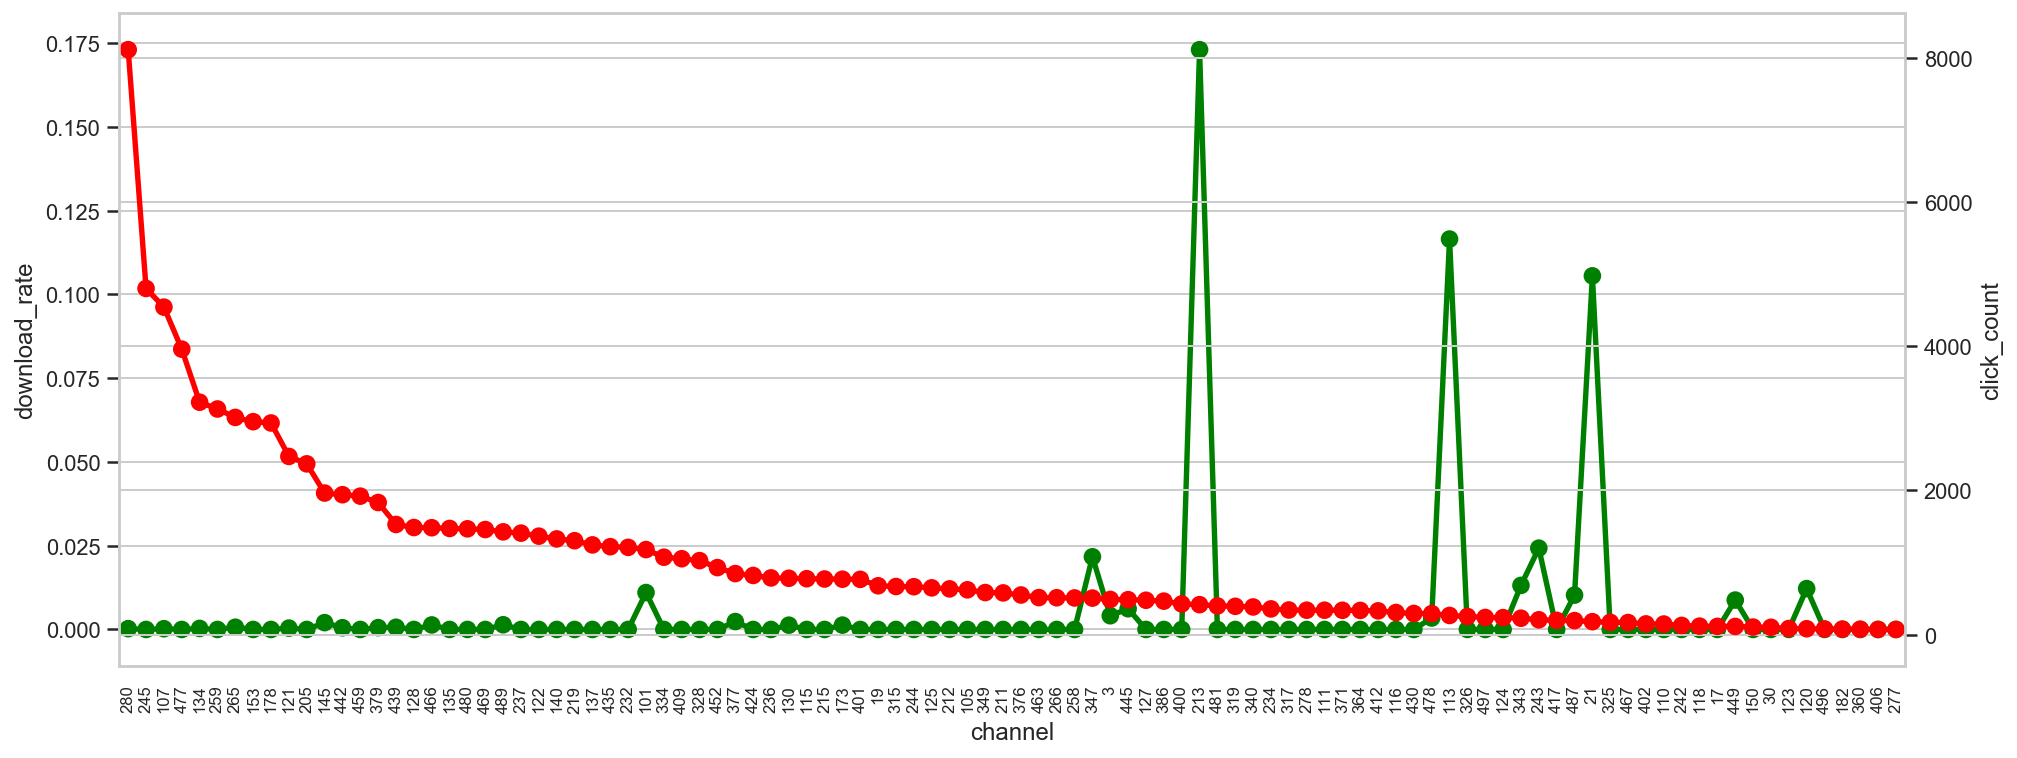

In [27]:
order_channel = channel_table["channel"].head(100).unique()

ax = sns.pointplot(data = channel_table[:100], x = "channel", y = "download_rate",
                   color = "green",
                   order = order_channel)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.twinx()

ax = sns.pointplot(data = channel_table[:100], x = "channel", y = "click_count",
                   color = "red",
                   order = order_channel)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize = "x-small")

plt.show()

접속 channel 역시 접속 횟수와 다운로드에는 상관 관계가 없어 보입니다.

## click_time 컬럼

### click_time_year

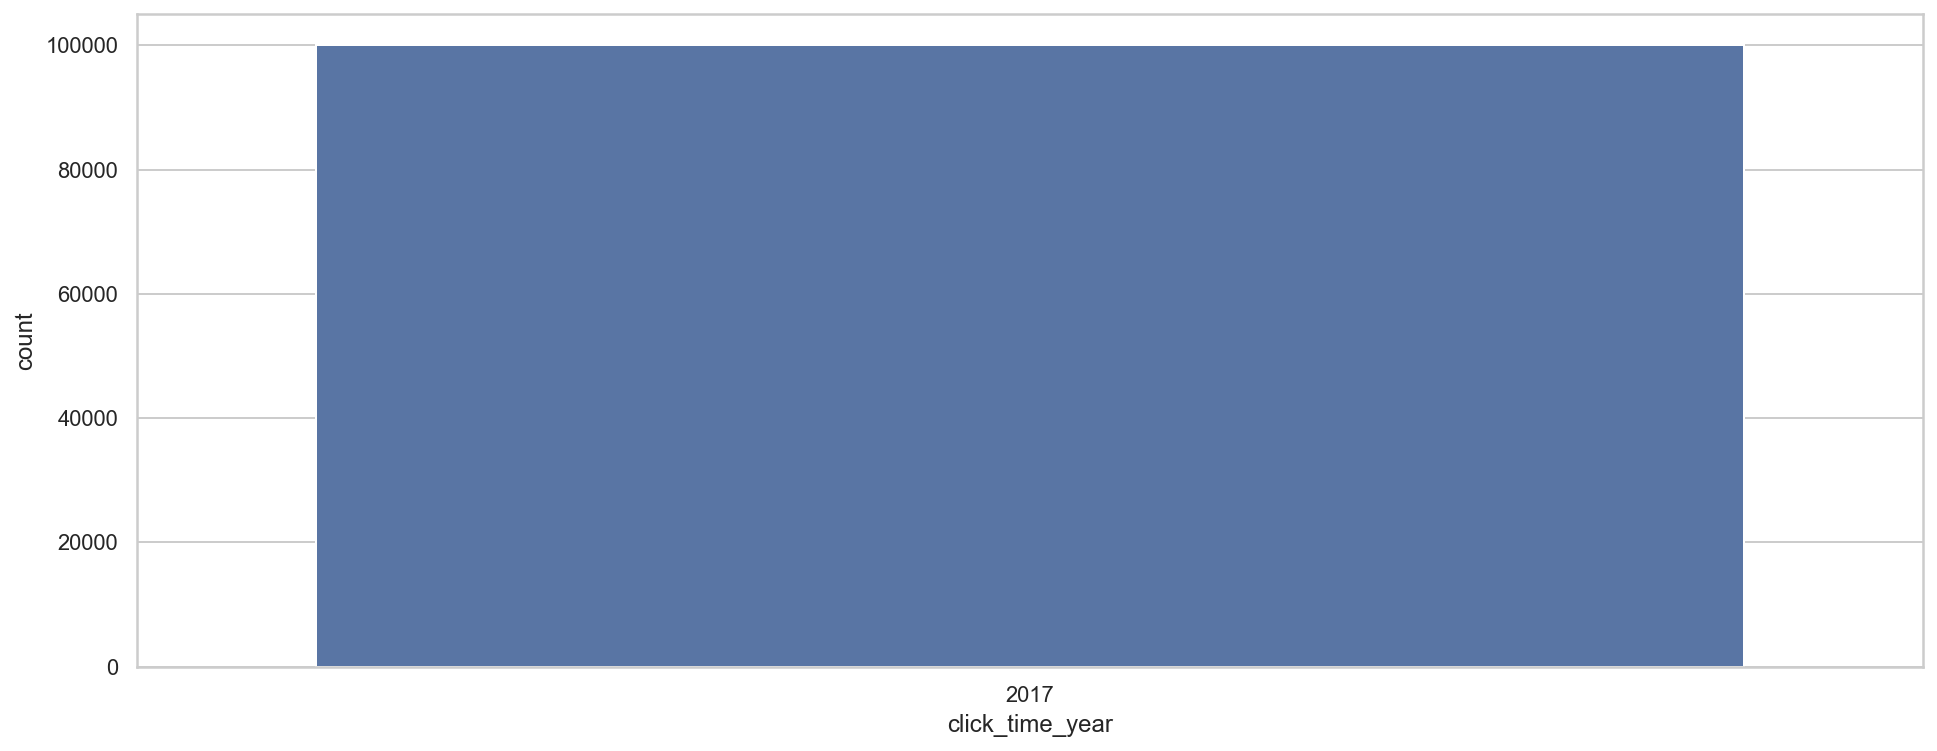

In [28]:
sns.countplot(data = train, x = "click_time_year")

plt.show()

### click_time_month

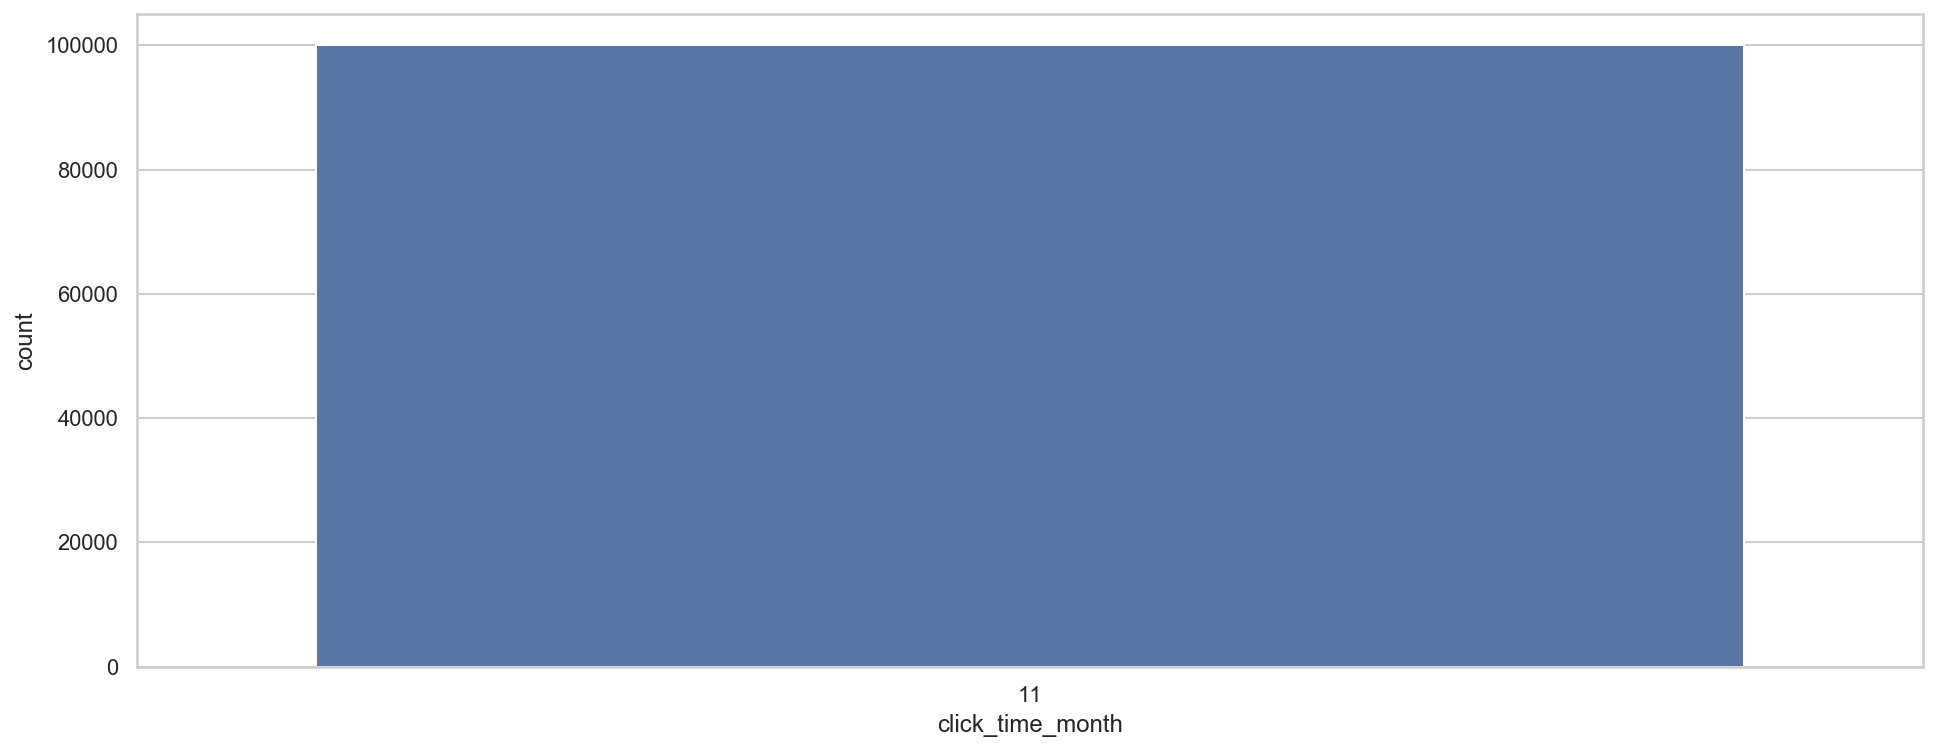

In [29]:
sns.countplot(data = train, x = "click_time_month")

plt.show()

### click_time_day

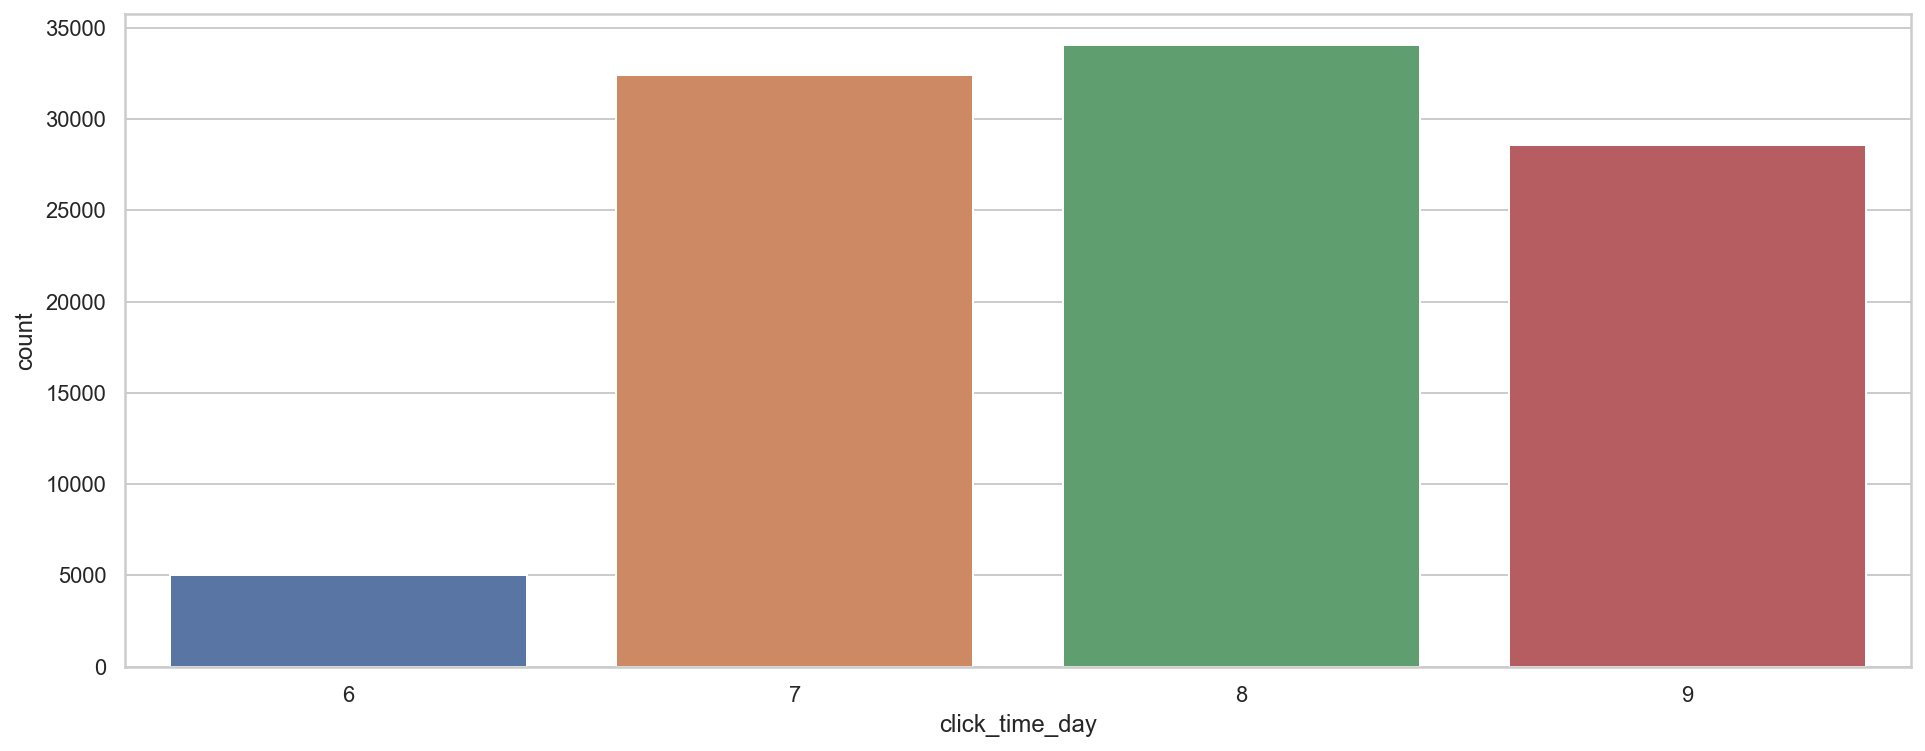

In [30]:
sns.countplot(data = train, x = "click_time_day")

plt.show()

### click_time_hour

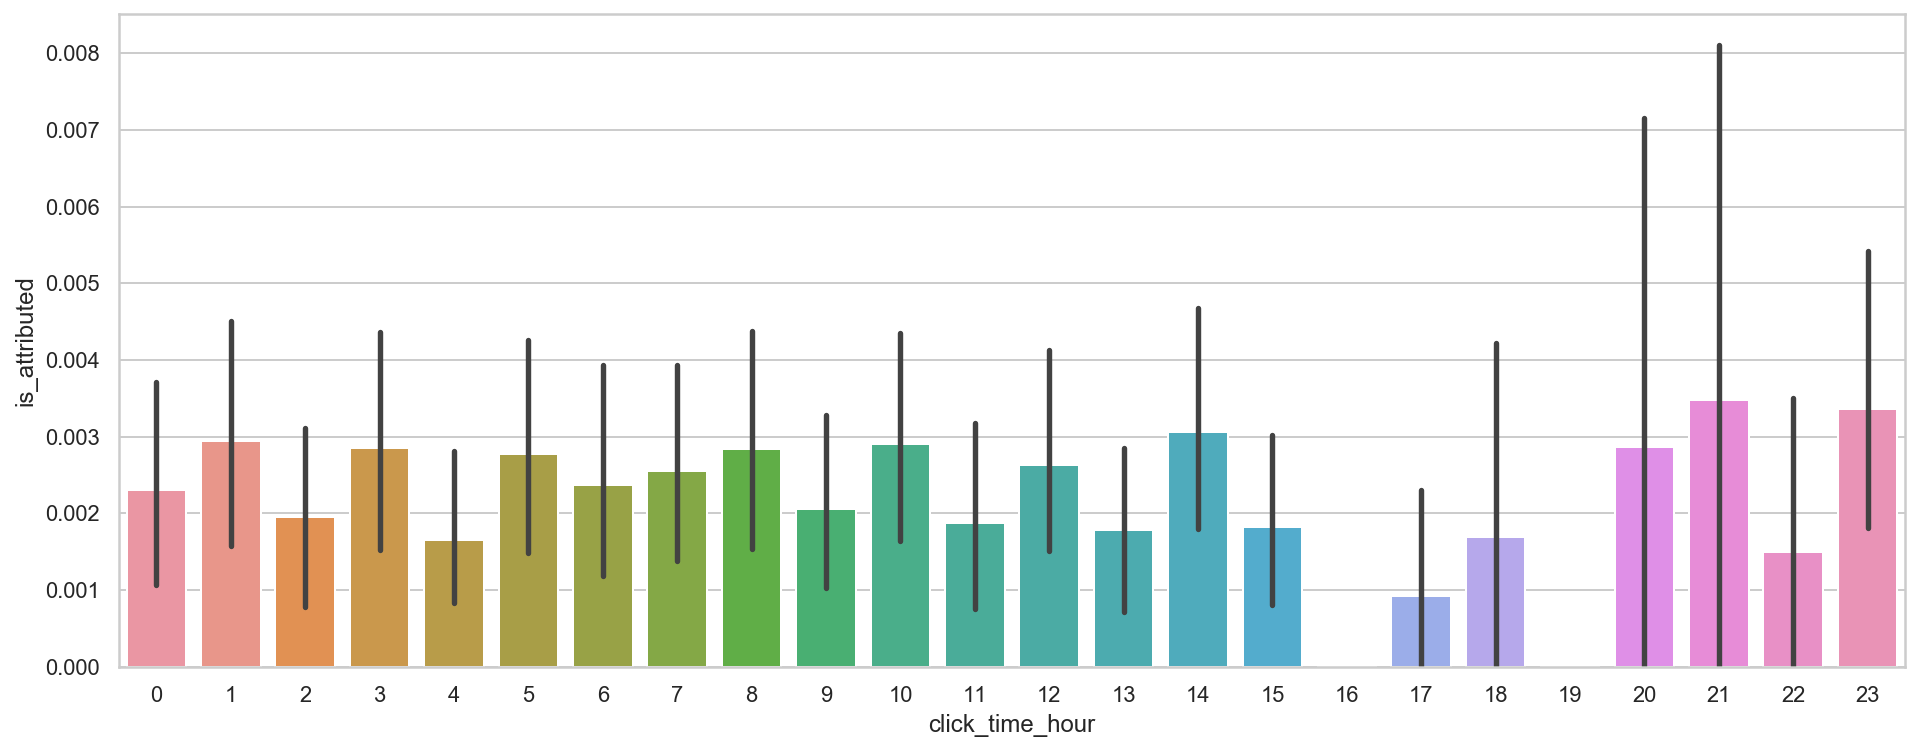

In [31]:
sns.barplot(data = train, x = "click_time_hour", y = "is_attributed")

plt.show()

In [32]:
day_table = pd.pivot_table(train, index = "click_time_hour",
                           values = "is_attributed",
                           aggfunc = ["mean", "count"])

day_table.columns = ["download_rate", "click_count"]

day_table = day_table.reset_index()

day_table

,click_time_hour,download_rate,click_count
0,0,0.002299,5654
1,1,0.002939,5103
2,2,0.001947,5137
3,3,0.002850,5264
4,4,0.001656,6039
5,5,0.002778,5400
6,6,0.002363,5079
7,7,0.002555,5089
8,8,0.002841,4576
9,9,0.002055,4867


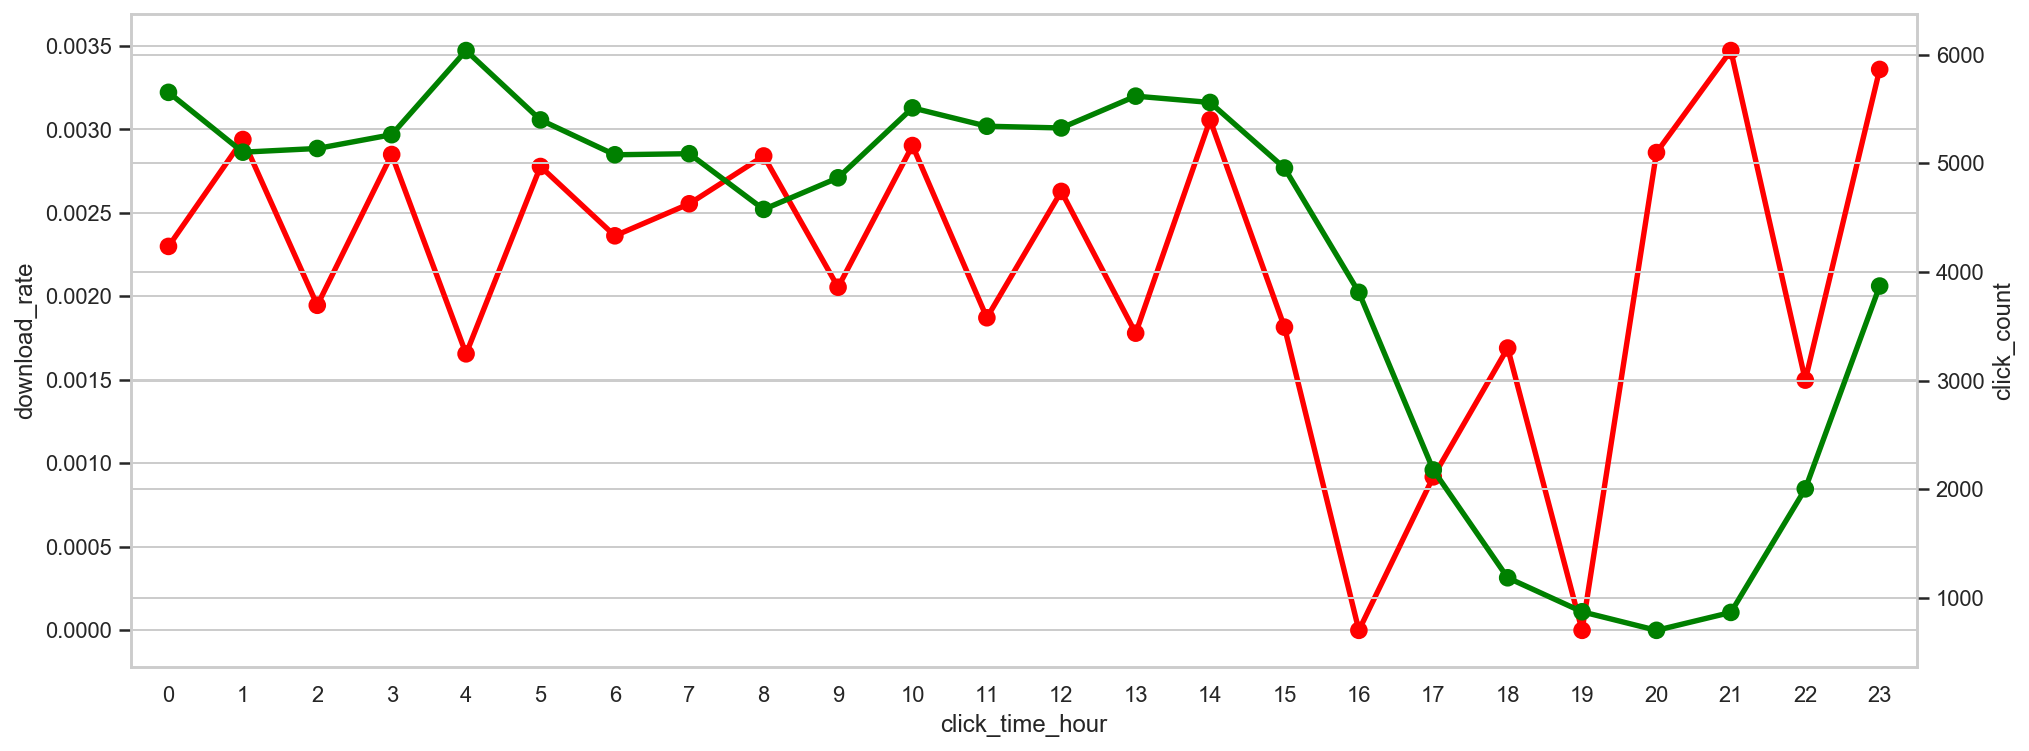

In [33]:
sns.pointplot(data = day_table, x = "click_time_hour", y = "download_rate", color = "red")

plt.twinx()

sns.pointplot(data = day_table, x = "click_time_hour", y = "click_count", color = "green")

plt.show()

전체적으로 접속 수가 적을 수록 높은 다운로드 비율을 보이고 있으며 특히 16, 20, 21시에 그 현상이 뚜렷하게 나타나는 것을 알 수 있습니다.

### click_time_minute

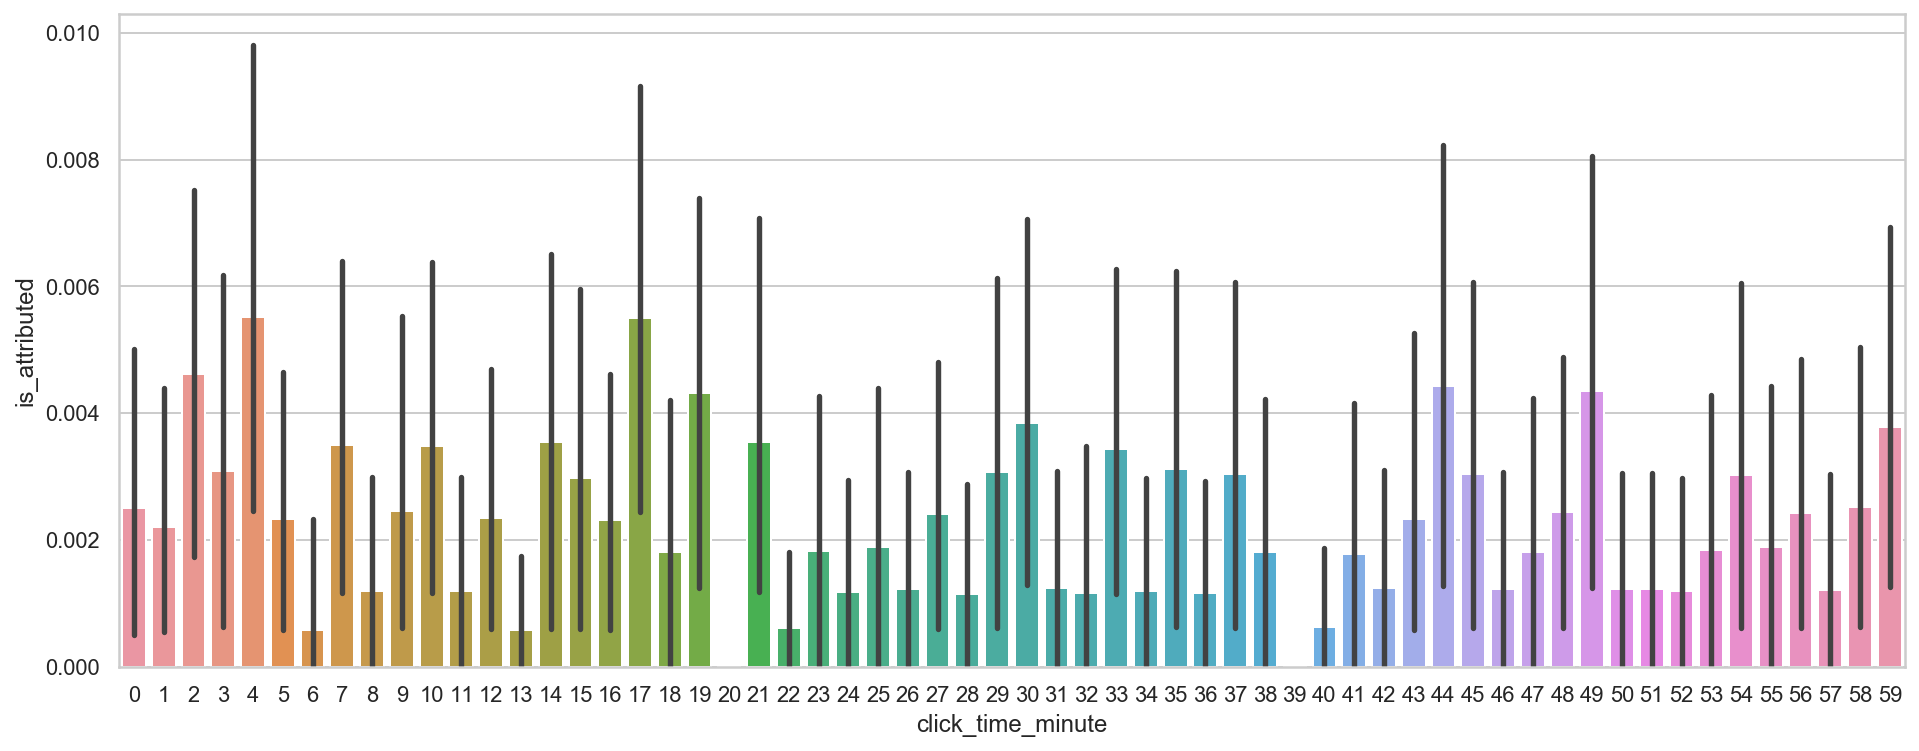

In [34]:
sns.barplot(data = train, x = "click_time_minute", y = "is_attributed")

plt.show()

10분 단위로 분을 변경하여 확인 하도록 하겠습니다.

In [35]:
train["click_time_minute_clean"] = (train["click_time_minute"] / 10).round() * 10

print(train.shape)
train[["click_time_minute", "click_time_minute_clean"]].head()

(100000, 21)


,click_time_minute,click_time_minute_clean
0,30,30.0
1,40,40.0
2,5,0.0
3,58,60.0
4,0,0.0


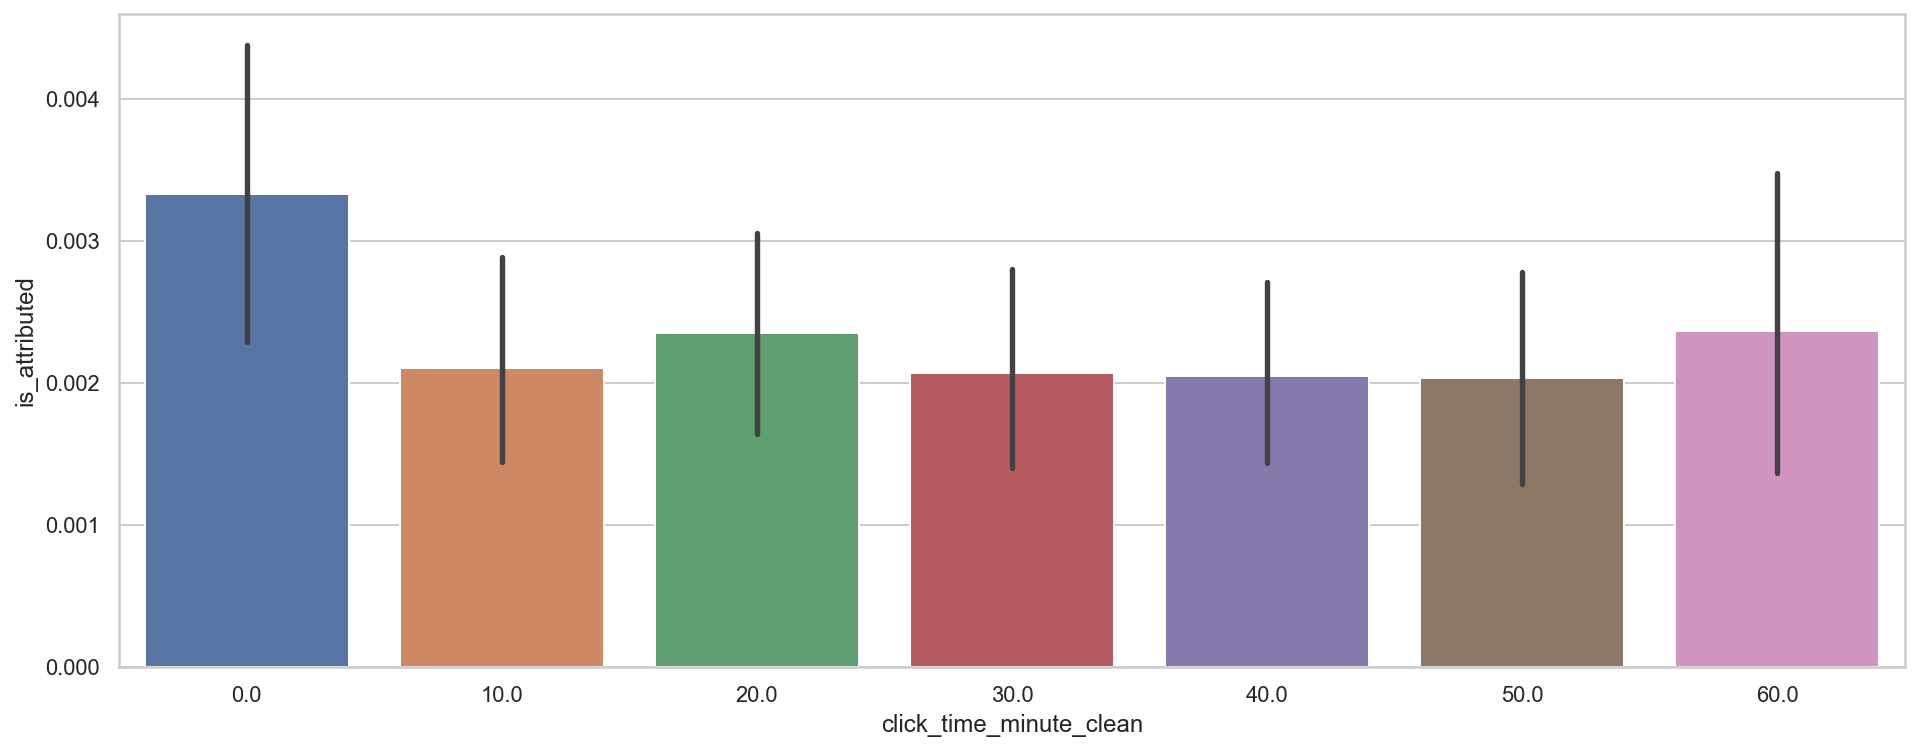

In [36]:
sns.barplot(data = train, x = "click_time_minute_clean", y = "is_attributed")

plt.show()

In [37]:
minute_table = pd.pivot_table(train, index = "click_time_minute_clean",
                           values = "is_attributed",
                           aggfunc = ["mean", "count"])

minute_table.columns = ["download_rate", "click_count"]

minute_table = minute_table.reset_index()

minute_table

,click_time_minute_clean,download_rate,click_count
0,0.0,0.003329,10514
1,10.0,0.002100,15238
2,20.0,0.002347,18322
3,30.0,0.002067,15001
4,40.0,0.002044,18104
5,50.0,0.002031,14772
6,60.0,0.002361,8049


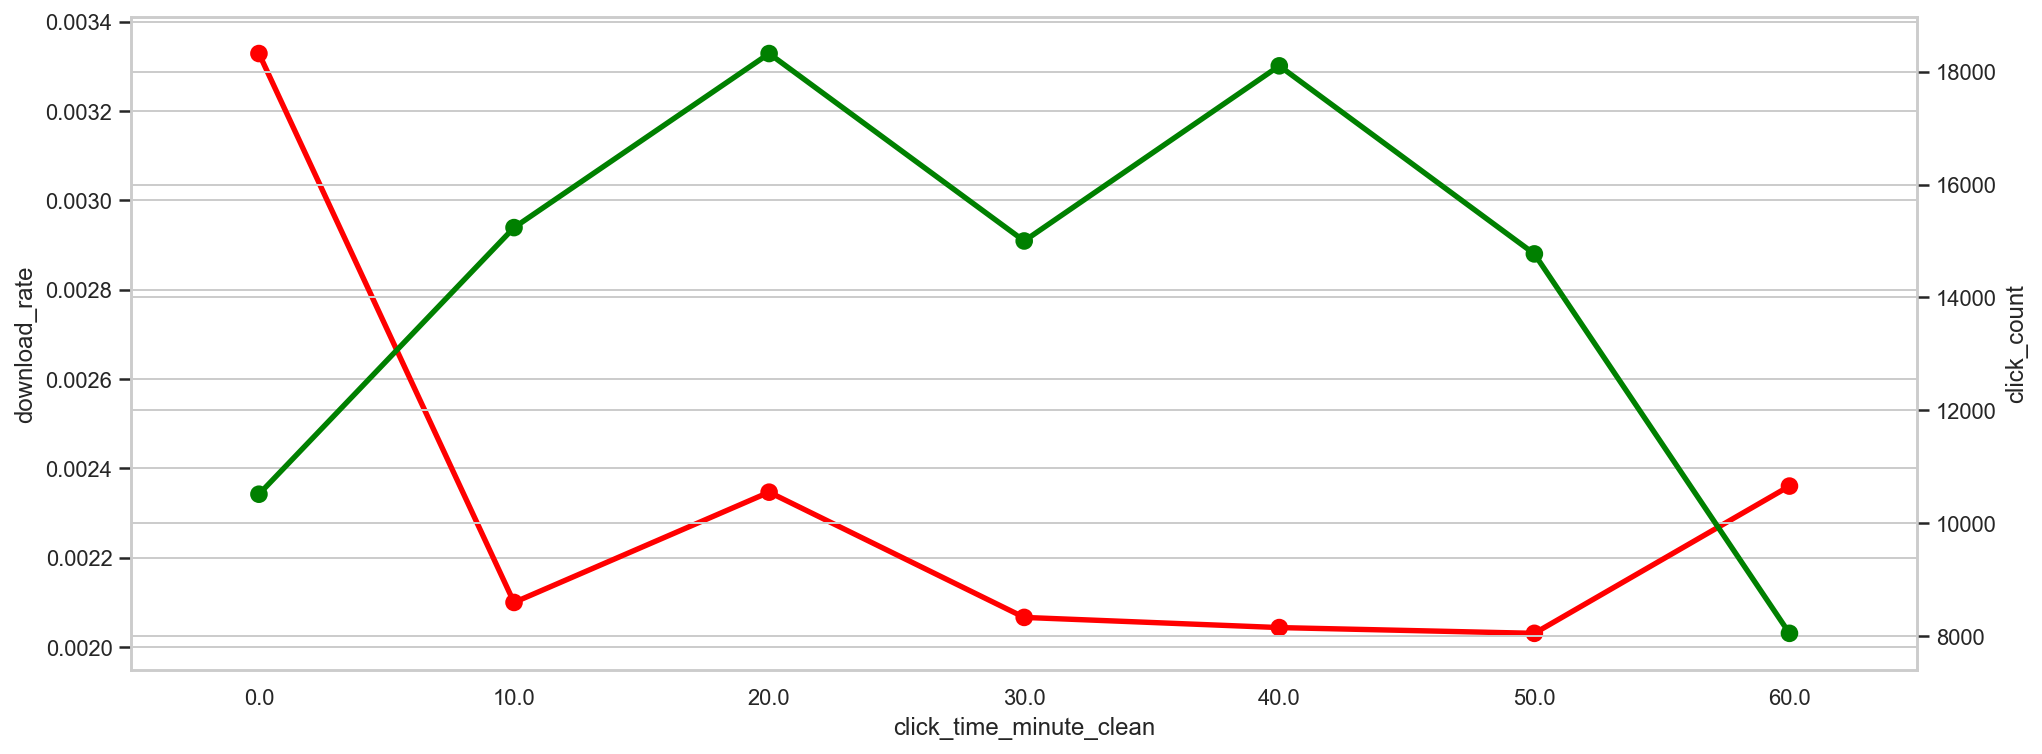

In [38]:
sns.pointplot(data = minute_table, x = "click_time_minute_clean", y = "download_rate", color = "red")

plt.twinx()

sns.pointplot(data = minute_table, x = "click_time_minute_clean", y = "click_count", color = "green")

plt.show()

분으로 확인 했을때도 클릭수가 낮을때 높은 다운로드 비율을 나타내는 것을 알 수 있습니다.

### click_time_weekday 컬럼

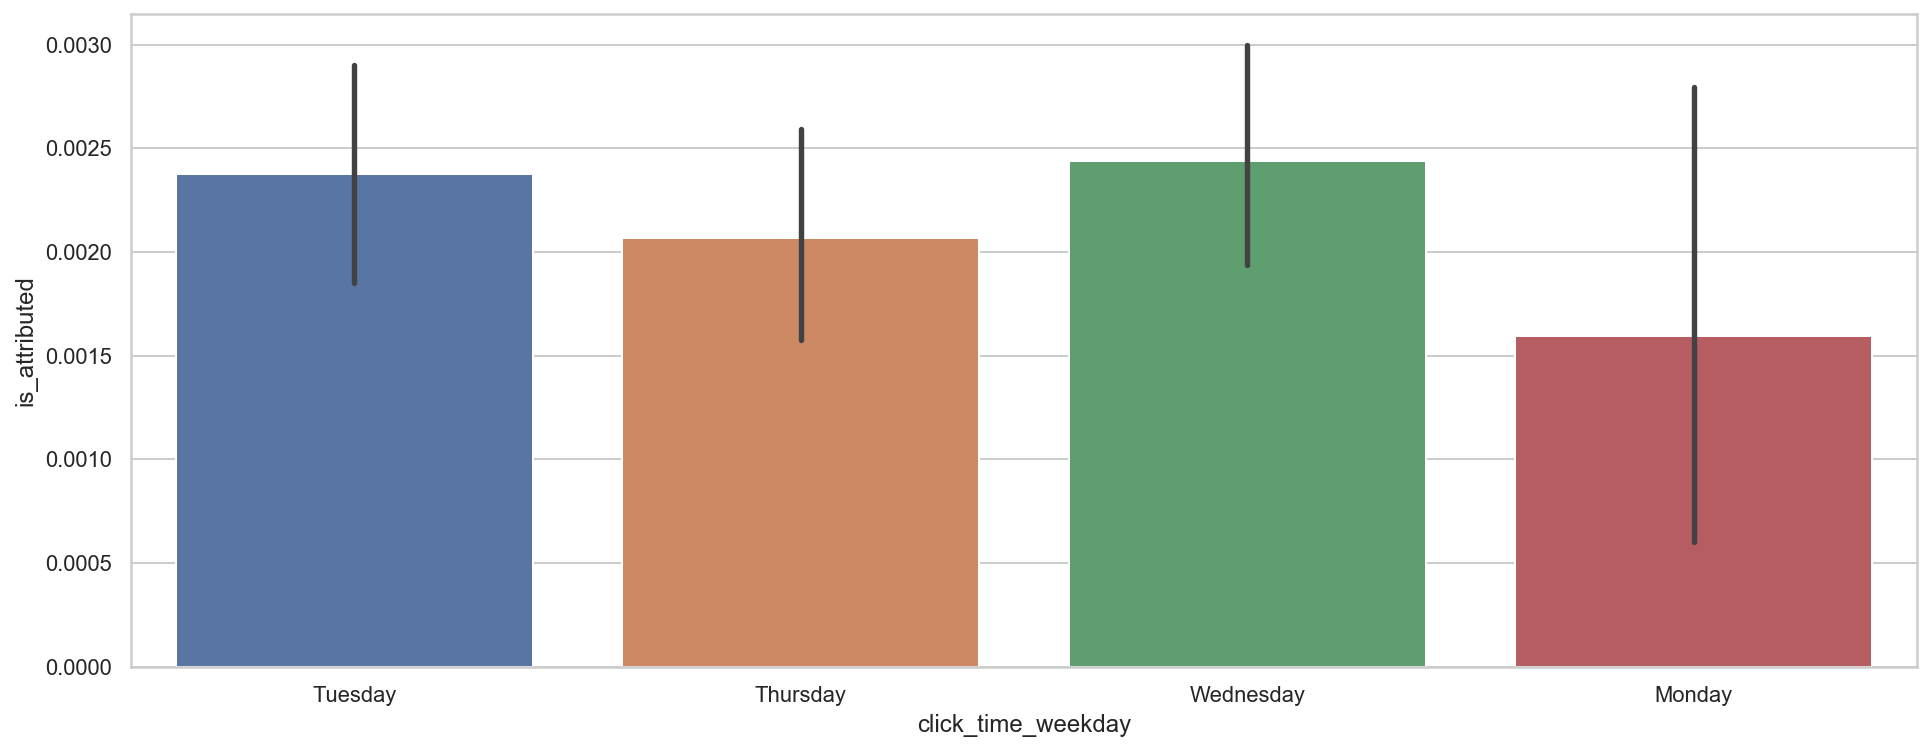

In [39]:
sns.barplot(data = train, x = "click_time_weekday", y = "is_attributed")

plt.show()

## 접속에서 다운로드까지 duration 확인

In [40]:
train["time_gap"] = train["attributed_time"] - train["click_time"]

train["time_gap"] = pd.to_datetime(train["time_gap"])

print(train.shape)
train[["click_time", "attributed_time", "time_gap"]].head()

(100000, 22)


,click_time,attributed_time,time_gap
0,2017-11-07 09:30:38,NaT,NaT
1,2017-11-07 13:40:27,NaT,NaT
2,2017-11-07 18:05:24,NaT,NaT
3,2017-11-07 04:58:08,NaT,NaT
4,2017-11-09 09:00:09,NaT,NaT


In [41]:
train["time_gap_minute"] = train["time_gap"].dt.second / 60 + train["time_gap"].dt.minute + train["time_gap"].dt.hour * 60

print(train.shape)
train[["time_gap", "time_gap_minute"]].head()

(100000, 23)


,time_gap,time_gap_minute
0,NaT,NaN
1,NaT,NaN
2,NaT,NaN
3,NaT,NaN
4,NaT,NaN


In [44]:
train_attributed = train[train["time_gap_minute"].notnull()]

print(train_attributed.shape)
train_attributed.head()

(227, 23)


,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_time_year,click_time_month,click_time_day,click_time_hour,click_time_minute,click_time_weekday,attributed_time_year,attributed_time_month,attributed_time_day,attributed_time_hour,attributed_time_minute,attributed_time_weekday,click_time_minute_clean,time_gap,time_gap_minute
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017,11,8,2,22,Wednesday,2017.0,11.0,8.0,2.0,22.0,Wednesday,20.0,1970-01-01 00:00:25,0.416667
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017,11,8,6,10,Wednesday,2017.0,11.0,8.0,6.0,10.0,Wednesday,10.0,1970-01-01 00:00:32,0.533333
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017,11,7,9,54,Tuesday,2017.0,11.0,7.0,11.0,59.0,Tuesday,50.0,1970-01-01 02:04:43,124.716667
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017,11,9,10,58,Thursday,2017.0,11.0,9.0,11.0,52.0,Thursday,60.0,1970-01-01 00:53:15,53.250000
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017,11,7,22,19,Tuesday,2017.0,11.0,8.0,1.0,55.0,Wednesday,20.0,1970-01-01 03:35:59,215.983333


In [45]:
duration = train_attributed["time_gap_minute"].astype(int).round().value_counts().reset_index()

duration.columns = ["minute", "count"]

duration.head()

,minute,count
0,0,65
1,1,32
2,2,14
3,3,7
4,5,5


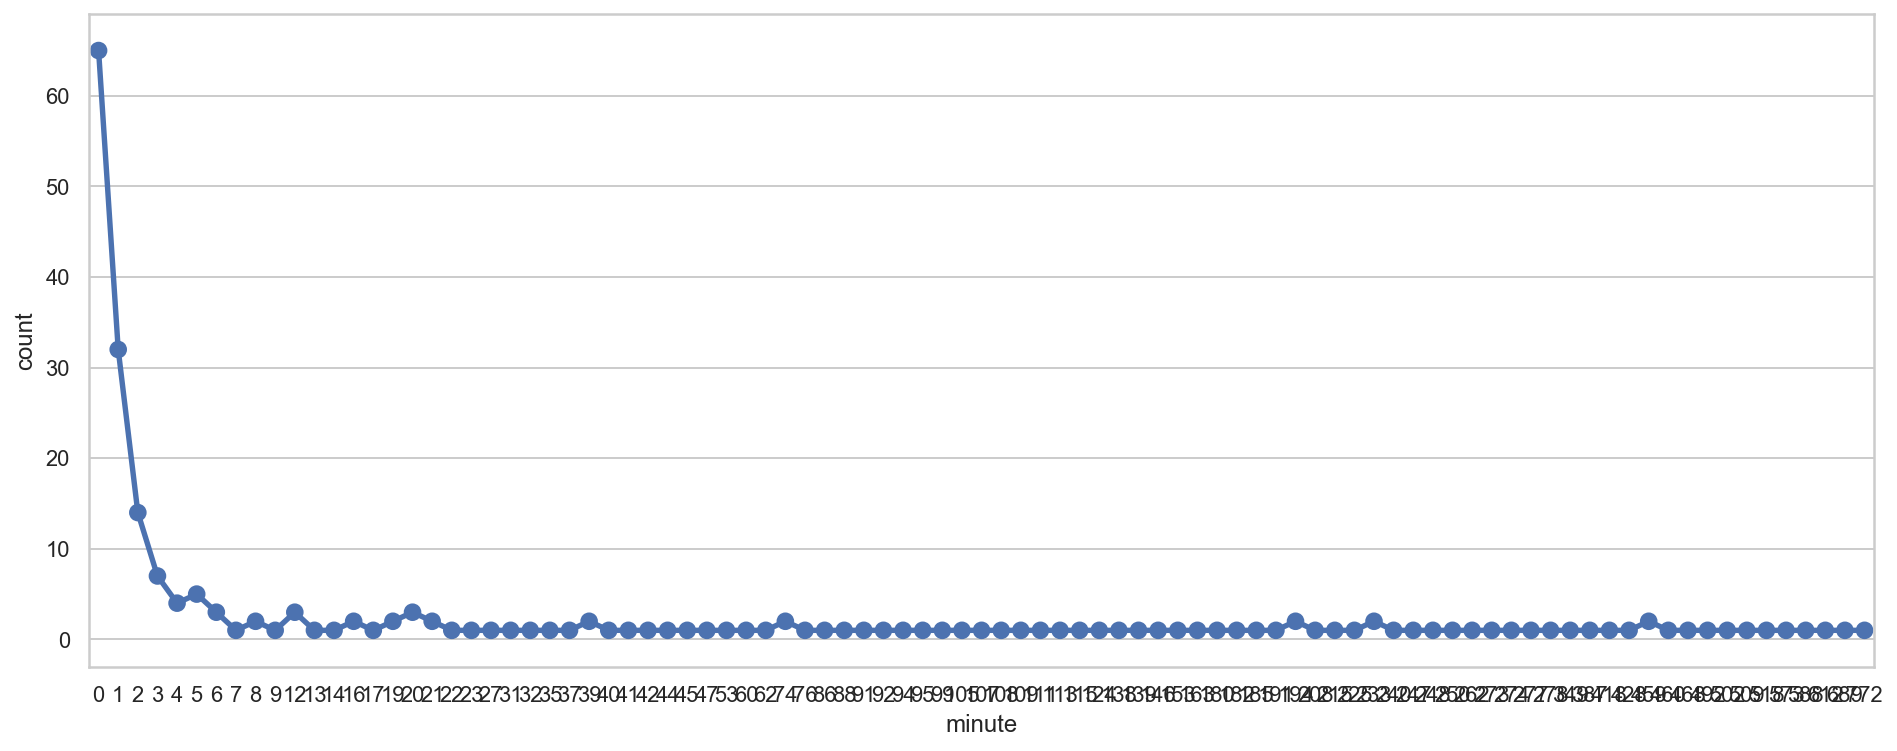

In [46]:
sns.pointplot(data = duration, x = "minute", y = "count")

plt.show()

대다수가 접속 후 1분 이내에 다운로드를 받는 것을 알 수 있습니다.

다운로드 목적을 가지고 있었다고 하더라도 1분이내에 다운을 받는것은 사람이 다운 받은 것이라고 생각하기 어렵습니다.

즉, 기계적인 도움이 없었다면 0분 이내에 다운을 받는 것은 불가능하다라는 생각이 듭니다.